<a href="https://colab.research.google.com/github/mepix/CropWeedClassification/blob/main/CropCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libaries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import time
import os
import copy
from torch.utils.data.sampler import WeightedRandomSampler
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Path to the Dataset
#path_to_data = '/content/gdrive/MyDrive/EE244/data/Split-Classes'

# Set the Batch Size & Hyperparameters
batch_size = 32
epochs = 100
eta = 0.001
imgDim = 224
step_size = 50
gamma = 0.01
do_three_classes = True

if do_three_classes:
  path_to_data_train = "/content/gdrive/MyDrive/EE244/data/Split-Classes-X3/Data-Train"
  path_to_data_test = "/content/gdrive/MyDrive/EE244/data/Split-Classes-X3/Data-Test"
  labels = ["Crop","Weed_Big","Weed_Small"]
else: #do the full dataset
  path_to_data_train = "/content/gdrive/MyDrive/EE244/data/Data-Train"
  path_to_data_test = "/content/gdrive/MyDrive/EE244/data/Data-Test"
  labels = ["Crop","Weed1","Weed2","Weed3","Weed4","Weed5","Weed6","Weed7","Weed8","Weed9"]

# Normalize to Zero Mean
transform = transforms.Compose(
    [
     transforms.Resize([224,224]),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #MEAN & STDDEV for ResNet
    ])

# Check GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Images from the Image Folder
# dataset = datasets.ImageFolder(root=path_to_data, transform=transform)

# Compute samples weight (each sample should get its own weight)
def getSampleWeights(dataset):
  target = torch.Tensor(dataset.targets).type(torch.LongTensor)
  print("Target Labels:",target)
  class_sample_count = torch.tensor(
      [(target == t).sum() for t in torch.unique(target, sorted=True)])
  print("Sample Count:",class_sample_count)
  weight = 1. / class_sample_count.float()
  print("Weights:",weight)
  samples_weight = torch.tensor([weight[t] for t in target])
  print("Samples Weights:",samples_weight)
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
  return sampler

# Split into Train and Test Set
# pct_test = 0.25
# train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=pct_test)
# data = {}
# data['train'] = Subset(dataset,train_idx)
# data['test'] = Subset(dataset,test_idx)

# Get Train & Test Set (With Weighted Random Sampling)
data = {}
data['train'] = datasets.ImageFolder(root=path_to_data_train, transform=transform)
data['test'] = datasets.ImageFolder(root=path_to_data_test, transform=transform)


# def multi2tri(data,verbose=False):
#   """Turns a MultiClass Dataset into a 3-Class Dataset"""
    #https://discuss.pytorch.org/t/change-labels-in-data-loader/36823/13
#   if verbose: print("Input Target Classes:",np.unique(data.targets))
#   data.targets = torch.tensor(data.targets).type(torch.LongTensor)
#   data.targets[data.targets > 2] = 2
#   if verbose: print("Output Target Classes:",np.unique(data.targets))
#   return data

#   for k in range(10):
#     if verbose: print(data.targets[data.targets == k])
#     data.targets[data.targets == k] = 2
#   # data.targets[data.targets > 2] = 2

#   return data


# if do_three_classes:
#   data['train'] = multi2tri(data['train'],True)
#   data['test'] = multi2tri(data['test'],True)

sampler = {}
sampler['train'] = getSampleWeights(data['train'])
sampler['test'] = None


# Build the Train and Test DataLoaders
dataloaders = {x:DataLoader(data[x],batch_size, num_workers=2,sampler=sampler[x]) for x in ['train','test']}
x,y = next(iter(dataloaders['train']))

# Rebundle Datasets
dataset_sizes = {
    'train':len(data['train']),
    'test':len(data['test'])}

# Check Sizes
print(x.shape, y.shape)
# print("Original Dataset",len(dataset))
print("Training Dataset",len(data['train']))
print("Testing Dataset",len(data['test']))
# for i, (x, y) in enumerate(dataloaders['train']):
#     print("batch index {}, 0/1: {}/{}".format(
#         i, (y == 0).sum(), (y == 1).sum()))


Target Labels: tensor([0, 0, 0,  ..., 2, 2, 2])
Sample Count: tensor([ 799, 1591,  576])
Weights: tensor([0.0013, 0.0006, 0.0017])
Samples Weights: tensor([0.0013, 0.0013, 0.0013,  ..., 0.0017, 0.0017, 0.0017])
torch.Size([32, 3, 224, 224]) torch.Size([32])
Training Dataset 2966
Testing Dataset 1032


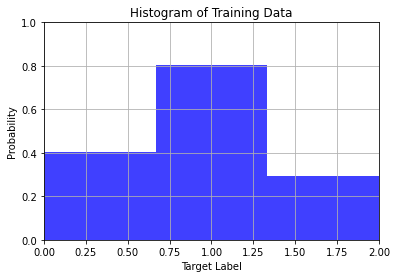

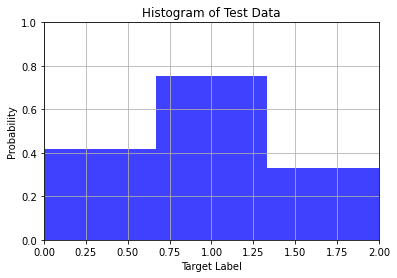

In [4]:
def plotHistogram(data,number_bins,title=None):
  """Plots the Histogram of the Given Dataset"""
  # https://matplotlib.org/stable/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py

  x = data.targets
  n, bins, patches = plt.hist(x, number_bins,density=True, facecolor='b', alpha=0.75)

  plt.xlabel('Target Label')
  plt.ylabel('Probability')
  plt.title(title)
  plt.xlim(0, number_bins-1)
  plt.ylim(0, 1)
  plt.grid(True)
  plt.show()

plotHistogram(data["train"],len(labels),"Histogram of Training Data")
plotHistogram(data["test"],len(labels),"Histogram of Test Data")

In [5]:
# Determine the MEAN and STD Manually and then re-run block
# mean = 0.0
# std = 0.0
# nb_samples = 0.0
# for data in dataloaders['train']: #assume same for test and train data 
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print(mean)
# print(std)
#print(dataset.data.shape)
# print(data['train'].mean(axis=(0,1,2))/255)
# print(trainset.data.std(axis=(0,1,2))/255)
#[0.49139968 0.48215841 0.44653091]
#[0.24703223 0.24348513 0.26158784]

# https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/15
# https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html
# https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6?u=ptrblck

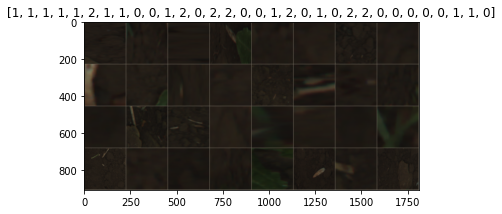

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Add back the mean and std for visualization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# INPUTS: a vector of images [batch_size,num_channels,height,width]
# CLASSES: an array containing the index of the appropriate class_names

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Visualize a sample set of images to verify we imported everything OK
imshow(out, title=[int(classes[x]) for x in range(batch_size)])

In [7]:
def getNetworkModel(model_type="ResNet",step_size=7,gamma=0.1):
  """Create the parameters necessary for the RESNET model"""
  # Load in the ResNet Model
  if model_type == "ResNet":
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
  else:
    return None #TODO: Try other Models

  # Determine the Number of Features
  # num_ftrs = modelResNet.fc.in_features

  # Size of each output sample is generalized to nn.Linear(num_ftrs, len(class_names))
  # model.fc = nn.Linear(imgDim*imgDim, len(class_names))

  # Push to GPU
  model = model.to(device)

  # Set the Loss Criterion
  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer = torch.optim.Adam(model.parameters(), lr=eta) #https://pytorch.org/docs/master/generated/torch.optim.Adam.html

  # Decay LR by a factor of 0.1 every 7 epochs TOO AGGRESSIVE FOR RESNET: 0.01  epoch80 0.001 epoch120 0.0001 (Mayve start at 60 or 40 for smaller data set)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  return model, criterion, optimizer, scheduler

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store training values in lists
    training_acc = []
    training_loss = []
    validation_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store Performance in Arrays
            if phase == 'train':
              training_loss.append(epoch_loss)
              training_acc.append(epoch_acc.item())
            else: # must be validation
              validation_acc.append(epoch_acc.item())


            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_acc, training_loss, validation_acc



In [9]:
def plotResults(training_loss,training_acc,test_acc,titleStr=""):
  """Plots the training_loss, training_acc, and test_acc with the provided title"""
  # Create Figure
  plt.figure(figsize=(15,3))
  plt.suptitle(titleStr, fontsize=15)

  # Training Loss Plot
  plt.subplot(131)
  plt.plot(training_loss)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Training Loss', fontsize=10)
  plt.grid(True)

  # Training Accuracy Plot
  plt.subplot(132)
  plt.plot(training_acc)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Training Accuracy', fontsize=10)
  plt.grid(True)

  # Test Accuracy Plot
  plt.subplot(133)
  plt.plot(test_acc)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Test Accuracy', fontsize=10)
  plt.grid(True)

  # Adjust Dimensions
  plt.subplots_adjust(wspace=.5)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/99
----------
train Loss: 1.2842 Acc: 0.4208
test Loss: 2.7997 Acc: 0.2771

Epoch 1/99
----------
train Loss: 1.0335 Acc: 0.4548
test Loss: 0.9838 Acc: 0.5426

Epoch 2/99
----------
train Loss: 1.0450 Acc: 0.4585
test Loss: 1.7368 Acc: 0.2742

Epoch 3/99
----------
train Loss: 1.0288 Acc: 0.4545
test Loss: 3.9122 Acc: 0.2781

Epoch 4/99
----------
train Loss: 1.0167 Acc: 0.4875
test Loss: 2.7142 Acc: 0.2771

Epoch 5/99
----------
train Loss: 1.0212 Acc: 0.4818
test Loss: 1.3534 Acc: 0.2868

Epoch 6/99
----------
train Loss: 1.0001 Acc: 0.5034
test Loss: 1.2577 Acc: 0.5281

Epoch 7/99
----------
train Loss: 0.9889 Acc: 0.5088
test Loss: 1.5852 Acc: 0.3062

Epoch 8/99
----------
train Loss: 1.0185 Acc: 0.4777
test Loss: 1.0163 Acc: 0.5048

Epoch 9/99
----------
train Loss: 1.0015 Acc: 0.4949
test Loss: 1.9160 Acc: 0.2791

Epoch 10/99
----------
train Loss: 0.9976 Acc: 0.5064
test Loss: 1.2379 Acc: 0.2568

Epoch 11/99
----------
train Loss: 0.9958 Acc: 0.4899
test Loss: 1.3311 Acc

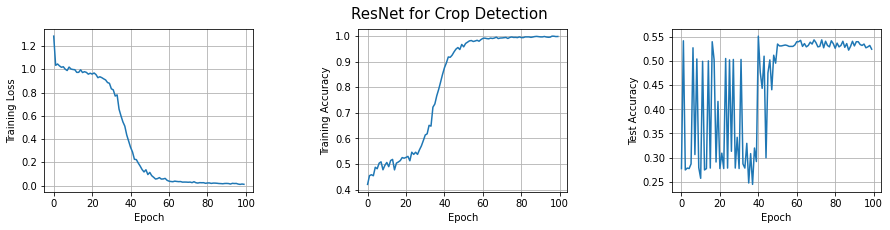

In [10]:
# Get a Clean Model for No Augmentation
model, criterion, optimizer, scheduler = getNetworkModel(step_size=step_size,gamma=gamma)

# Train the Network
model_conv, train_acc, train_loss, test_acc = train_model(model, criterion, optimizer,scheduler, num_epochs=epochs)

# Plot the Results
plotResults(train_loss, train_acc, test_acc,titleStr="ResNet for Crop Detection")

tensor([[102., 185.,   0.],
        [ 50., 468.,   0.],
        [ 21., 206.,   0.]])
tensor([[0.3554, 0.3571, 0.0000],
        [0.1742, 0.9035, 0.0000],
        [0.0732, 0.3977, 0.0000]])
tensor([0.3554, 0.9035, 0.0000])


array([[0.3554007 , 0.35714287, 0.        ],
       [0.17421603, 0.9034749 , 0.        ],
       [0.07317073, 0.3976834 , 0.        ]], dtype=float32)

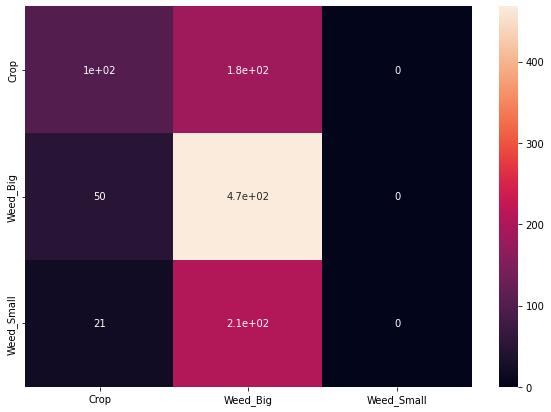

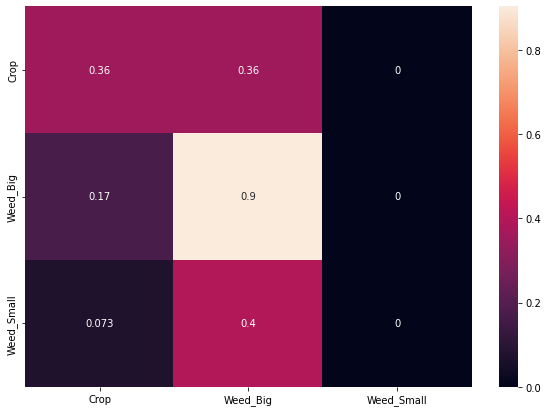

In [11]:
def getConfusionMatrix(dataloader,number_classes,verbose=True):
  """Calculates the Confusion Matrix for the given dataloader"""
  # https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
  
  # Create a placeholder matrix
  confusion_matrix = torch.zeros(number_classes, number_classes)

  # Fill out the confusion Matrix
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  
  confusion_matrix_percent = confusion_matrix/confusion_matrix.sum(1)

  # Print the array outputs
  if verbose:
    print(confusion_matrix)
    print(confusion_matrix_percent)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))

  return confusion_matrix, confusion_matrix_percent

def plotConfusionMatrix(confusion_matrix,labels=None):
  """Plots the Confusion Matrix and returns generated NumPy Array"""
  # Convert GPU Tensor to CPU Numpy Array
  confusion_matrix_np = confusion_matrix.cpu().detach().numpy()

  # Convert to Pandas Frame
  confusion_matrix_df = pd.DataFrame(
      confusion_matrix_np,
      index = labels,
      columns = labels)
  plt.figure(figsize = (10,7))
  sn.heatmap(confusion_matrix_df, annot=True)

  # Return the Numpy Array
  return confusion_matrix_np

conf_mat, conf_mat_pct = getConfusionMatrix(dataloaders['test'],len(labels))
plotConfusionMatrix(conf_mat,labels)
plotConfusionMatrix(conf_mat_pct,labels)